# Modeling & Data Analysis for the "Sentiment" dataset provided by Prof. Ugur Kursuncu
**Assignment:**
* Perform a descriptive statistical analysis of the data and make interesting inferences.
* Create models that predict the probability of each type of sentiment for each tweet.
* Design and explain the data science pipeline followed in this task involving Data preprocessing, Data Analysis, Feature Engineering, Modeling, and Evaluation.

**Dataset:** https://drive.google.com/drive/folders/1bjjhdDZbHR4reXwbcrqLC3-1vYadas7r?usp=sharing

**Professor:** Dr. Ugur Kursuncu

**Author:** Bishal Shrestha

**Date:** 9th April 2023

## Summary of my findings:
> **Finding 1:** The dataset is imbalanced: 48.4% are neutral, 37.2% are positive and 14.5% are negative.  

> **Finding 2:** The "baseline accuracy" of the model for each training, validation (dev set according to the question), and test dataset are approximately 48.4%, 44.7%, and 44.1%, respectively.  

> **Finding 3:** The distribution plot of training dataset lengths (# of characters) shows that 99.9% of the Twitter text has less than 150 characters. Hence, these tweets can be trimmed to 150 characters.

> **Finding 4:** I predicted the language for the tweets using `langdetect` and observed several languages, including 'fr', 'af', etc. However, when I read the tweets, they all appear to be in English. Hence, I did not find predicting language to be an interesting direction to pursue.

> **Finding 5**: Comparing the word frequency distribution of the words in the tweets for the three classes, I find that there are no words that could be used as a marker/sign of a particular class.

> **Finding 6:** There are 5,466 unique words in the entire dataset, which is only a small portion of the English language vocabulary. This suggests that the data can be prone to overfitting issues, and third-party word embeddings can be helpful. It also helps me decide the 'vocabulary size' parameter for the word embedding tasks.

> **Finding 7:** The first model trained, a Bi-LSTM with one-hot encoded vector sequence, achieves an accuracy of 60.1% on the test dataset in 5 epochs. After five epochs, the model starts to overfit.

> **Finding 8:** 'Class weighting', to account for the imbalanced dataset, did not improve the accuracy of the Bi-LSTM model.

> **Finding 9:** Using the 'self-trained word embedding' also did not improve the accuracy of the Bi-LSTM model.

> **Finding 10:** The use of padding in the embedding also did not improve the model's accuracy.

> **Finding 11:** Replacing word embeddings trained locally with `GloVe` embedding increased the accuracy to 65%, **around a 5% increase**. Similar improvement is observed across other metrics (precision, recall, and F1-score).

> **Finding 12:** The second model trained, a transformer network, only achieved an accuracy of 58.3% accuracy. Since transformer networks work well when the dataset is large, I assume that this is 'expected' for our dataset. 

###Notes: 
* Since Sklearn was not a requirement for this task and state of the art techniques such as attention networks are not available in sklearn, I choose to use Tensorflow/Keras.
* In this notebook, although I do not explicitly explain the data science pipeline, since I have explained and annotated all of my steps, I am hoping that the entire notebook serves the purpose.
* This notebook is created by following the principles of writing and sharing Notebooks from "Ten simple rules for writing and sharing computational analyses in Jupyter Notebooks" (Reference: https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007007)

## Connecting notebook to Google Drive to work on the project folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/Sentiment Analysis/
!pwd

Mounted at /content/drive
/content/drive/My Drive/Sentiment Analysis
/content/drive/My Drive/Sentiment Analysis


##Importing the SemEval tweets dataset from Google Drive
The `TrainingData` contains additional labels such as 'objective-OR-neutral', and 'objective' that is to be changed to 'neutral'.  
Since the training of model requires Validation Dataset, the `DevData` is not kept as Validation Dataset.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.read_csv('SemEval-tweets/TrainingData.tsv', sep='\t', header=None, names=['ID', 'SN', 'y', 'x'])
test_df = pd.read_csv('SemEval-tweets/TestData.tsv', sep='\t', header=None, on_bad_lines='skip', names=['ID', 'SN', 'y', 'x'])
val_df = pd.read_csv('SemEval-tweets/DevData.tsv', sep='\t', header=None, names=['ID', 'SN', 'y', 'x'])

print("Shape of train_df: ", train_df.shape)
print("Shape of test_df: ", test_df.shape)
print("Shape of val_df: ", val_df.shape)

# Combining the train_df and dev_df
# train_df = pd.concat([train_df, dev_df], ignore_index=True)

# replace any occurrence of 'objective-OR-neutral' and 'objective' with 'neutral' in the 'y' column
train_df['y'] = train_df['y'].replace(['objective-OR-neutral','objective'], 'neutral')

Shape of train_df:  (8002, 4)
Shape of test_df:  (3137, 4)
Shape of val_df:  (1381, 4)


Before proceeding further, I would like to check if the dataset contains any null elements.

In [ ]:
# Checking for null values
print("train_df")
for col in train_df.columns:
    print(col, train_df[col].isnull().sum())

print("\nval_df")
for col in val_df.columns:
    print(col, val_df[col].isnull().sum())

print("\ntest_df")
for col in test_df.columns:
    print(col, test_df[col].isnull().sum())

train_df
ID 0
SN 0
y 0
x 0

val_df
ID 0
SN 0
y 0
x 0

test_df
ID 0
SN 0
y 0
x 0


## Performing Statistical Data Analysis
**First, it is important to check the frequency distribution of the target classes.**  
Since the performance of the model depends upon the dataset it is trained on, this will provide informative result in predicting the model's performance.

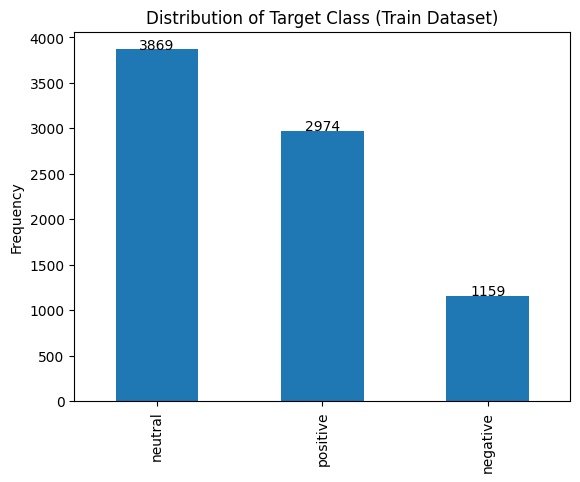

In [ ]:
# Get the frequency distribution of column 'A'
freq_dist = train_df['y'].value_counts()

# Plot the frequency distribution as a bar chart
ax = freq_dist.plot(kind='bar')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Target Class (Train Dataset)')

# Add text labels to the plot
for i, v in enumerate(freq_dist.values):
    ax.text(i, v, str(v), ha='center')

plt.show()

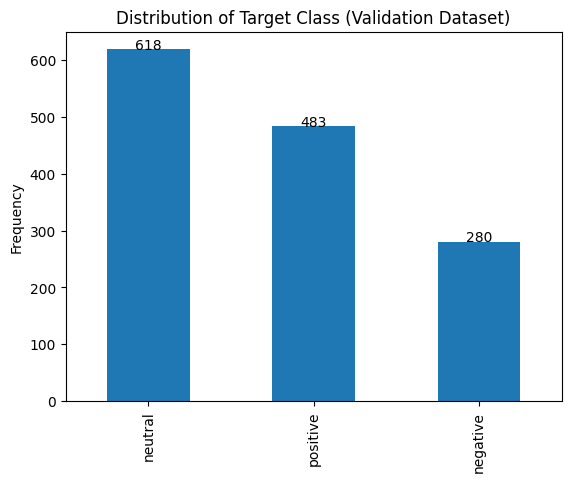

In [ ]:
# Get the frequency distribution of column 'A'
freq_dist = val_df['y'].value_counts()

# Plot the frequency distribution as a bar chart
ax = freq_dist.plot(kind='bar')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Target Class (Validation Dataset)')

# Add text labels to the plot
for i, v in enumerate(freq_dist.values):
    ax.text(i, v, str(v), ha='center')

plt.show()

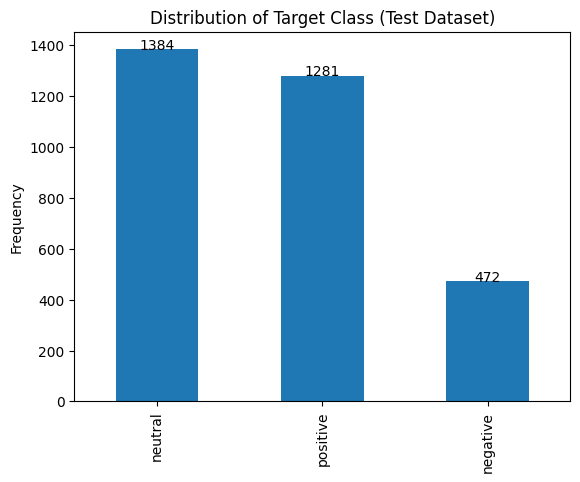

In [ ]:
# Get the frequency distribution of column 'A'
freq_dist = test_df['y'].value_counts()

# Plot the frequency distribution as a bar chart
ax = freq_dist.plot(kind='bar')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Target Class (Test Dataset)')

# Add text labels to the plot
for i, v in enumerate(freq_dist.values):
    ax.text(i, v, str(v), ha='center')

plt.show()

> **Finding 1:** From above three plots, it is apparent that the dataset is imbalanced: 48.4% are neutral, 37.2% are positive and 14.5% are negative.
An ideal dataset would have balanced distribution of the target class.  
* This class imbalance can produce: 
  1. Biased model - lean towards majority class
  2. Overfit to majority class - poor generalization
  3. Low recall on the minority classes
* Possible solutions to the class imbalance problem are:
  1. Undersampling of majority class
  2. Oversampling of minority classes
  3. Weighted loss
  4. Data augmentation

> **Finding 2:** The "baseline accuracy" of the model for each training, validation (dev set according to the question), and test dataset are approximately 48.4%, 44.7%, and 44.1%, respectively.  
  > This is calculated by diving the frequency of the majority class by the total data points in that dataset.  
  This is useful to know the performance of the model. Any model that has accuracy below that baseline accuracy can not be considered as a good model.

**After establishing the baseline accuracy of the model, I would like to find the length distribution of the tweets.**  
It is important to find the distribution of the tweets length to avoid unnecessary padding of the word embedding.

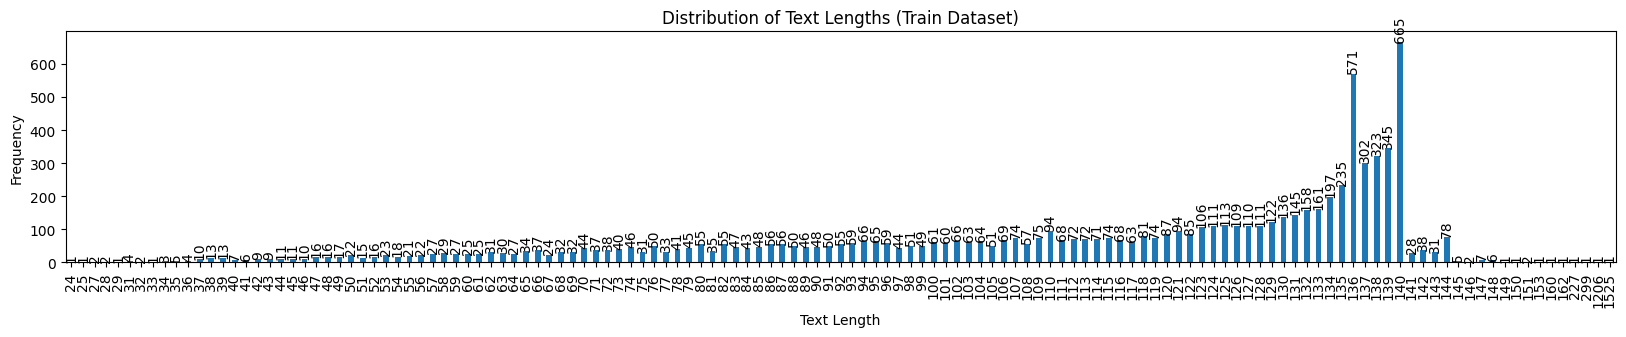

In [ ]:
# Compute the length of each text in column 'x'
train_df['text_lengths'] = train_df['x'].apply(lambda x: len(x))

# Get the frequency distribution of the 'text_lengths' column
freq_dist = train_df['text_lengths'].value_counts().sort_index()

fig = plt.figure(figsize=(20, 3))

# Plot the frequency distribution as a bar chart
ax = freq_dist.plot(kind='bar')
ax.set_xlabel('Text Length')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Text Lengths (Train Dataset)')

# Add the frequency above each bar
for i, v in enumerate(freq_dist):
    ax.text(i, v, str(v), ha='center', va='bottom', rotation=90)
    
plt.show()

The above plot of text length distribution shows that majority of the twitter texts length is below 144 characters.  

**Now, I would like to plot Probability Density Function to confirm the conclusion made from the above plot.**

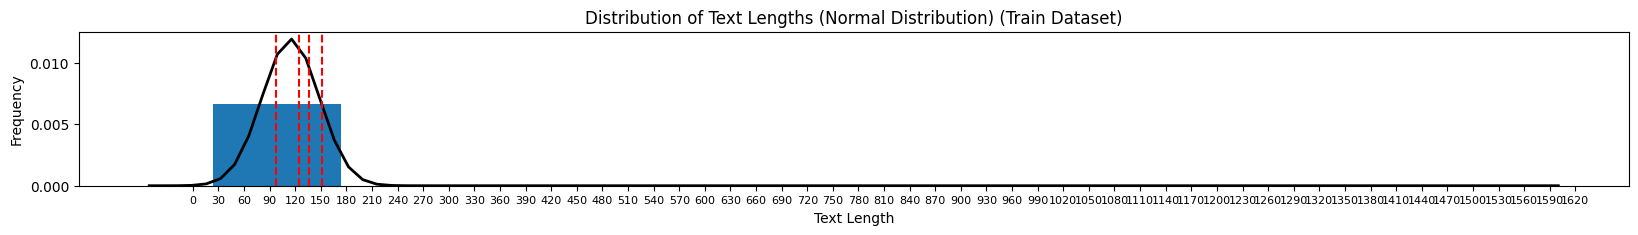

In [ ]:
import numpy as np
from scipy.stats import norm

# Compute the percentile values of the text lengths
percentiles = np.percentile(train_df['text_lengths'], [25, 50, 75, 99.9])

# Plot the frequency distribution as a normal distribution with percentile values
fig = plt.figure(figsize=(20, 2))
ax = fig.add_subplot(111)
mu, std = norm.fit(train_df['text_lengths'])
ax.hist(train_df['text_lengths'], density=True)
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2)
ax.set_xlabel('Text Length')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Text Lengths (Normal Distribution) (Train Dataset)')
ax.set_xticks(np.arange(0, xmax + 30, 30))
ax.tick_params(axis='x', which='major', labelsize=8)

# Add vertical lines for percentile values
for i, percentile in enumerate(percentiles):
    ax.axvline(percentile, color='r', linestyle='--')

plt.show()

> **Finding 3:** The distribution plot of training dataset lengths (# of characters) shows that 99.9% of the Twitter text has less than 150 characters. Hence, these tweets can be trimmed to 150 characters.



---


**Now, Let us find language of the tweets since every language has it's own punctuations: end of word or end of sentence marker.**

In [ ]:
!pip install langdetect
from langdetect import detect

# Define a function to detect the language of a given text
def detect_language(text):
    try:
        lang = detect(text)
    except:
        lang = 'unknown'
    return lang

# Apply the language detection function to the 'x' column of the dataframe
train_df['language'] = train_df['x'].apply(detect_language)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 52.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993243 sha256=b3c4ac78c75031936bdc1b7ac743f90573516c79d9de163b3d411a52dadc233a
  Stored in directory: /root/.cache/pip/wheels/d1/c1/d9/7e068de779d863bc8f8fc9467d85e25cfe47fa5051fff1a1bb
Successfully built langdetect


In [ ]:
train_df['language'].unique()

array(['en', 'fr', 'af', 'no', 'nl', 'tl', 'it', 'cy', 'id', 'fi', 'hr',
       'sv', 'so', 'es', 'ro'], dtype=object)

In [ ]:
train_df[train_df['language'] != 'en']

,ID,SN,y,x,text_lengths,language
168,228956189000597505,501134907,positive,Han mon dieu le remix de I am the best dans Dr...,71,fr
402,263897283618287617,452667901,negative,Rugby tonight and it's like freezing omg I may...,50,af
486,261902296210886656,26060394,positive,@923NowFM @jenniferhudson just saw jennifer Hu...,96,no
617,264257335659200512,246045811,neutral,I want to go watch Denzel's new movie tomorrow...,74,nl
641,228113092670791681,636149049,neutral,Free hugging day?tapos may Free Kissing Day? o...,104,tl
1150,264153269306277888,472283764,neutral,realizing tomorrow is Friday&gt;&gt;&gt; then ...,299,nl
1590,259653008311328769,881674926,neutral,@sarafinaab @Adesto Stasera ho guadato due fil...,139,it
2034,172575454849540096,269301788,neutral,Sarah G. Day last Sunday!! Monday!! Tuesday!! ...,110,tl
2171,245670284840026112,621161326,positive,Imaaa get it tomorrow. (;,25,nl
2414,264176275655106560,605024856,positive,"@addismom22 Feb 22 at KFC YUM center, you down?!",48,cy


> **Finding 4:** I predicted the language for the tweets using `langdetect` and observed serveral languages including 'fr', 'af', etc. However, when I read the tweets, they all appear to be in English. Hence, I did not find predicting language to be an interesting direction to pursue.

---

## Performing Data Pre-Processing

#### Encoding the target classes
Since the problem is `multi-label classification`, we need to perform appropriate encoding of the target classes.
- Label / Ordinal Encoding: This is not suitable for this dataset since we do not want to consider any order of priority between the class labels.
- One-Hot / Dummy Encoding: This is suitable for our problem since this does not consider any order between the target classes.

Therefore, let us perform One-Hot Encoding to our target column.


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Encode the target column as one-hot vectors
encoder = OneHotEncoder(sparse_output=False)
y_train = encoder.fit_transform(train_df['y'].values.reshape(-1, 1))
y_val = encoder.fit_transform(val_df['y'].values.reshape(-1, 1))
y_test = encoder.transform(test_df['y'].values.reshape(-1, 1))

# Get the mapping of labels to indices
label_mapping = dict(zip(encoder.categories_[0], range(len(encoder.categories_[0]))))
print(label_mapping)

{'negative': 0, 'neutral': 1, 'positive': 2}


#### Now, I would like to perform cleaning of the raw tweets.  
Some of the standard procedures that is relevent for the tweets can be:
1. Lowercasing
2. Removing URL's
3. Removing usernames
4. Removing the '#'s from the hashtags (the text of the hashtags might contain userful information. For e.g., #happy, #sad, etc.)
5. Removing special characters
6. Expanding Contractions
7. Removing punctuations and stop words
6. Lemmatization (better than Stemming because lemmatization will find the morphological root)

In [ ]:
!pip install contractions
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import string
import contractions

# Define a function to preprocess a text
def preprocess_text(text):

  # Convert to lowercase
  text = text.lower()
  
  # Remove URLs
  text = re.sub(r'http\S+', '', text)
  
  # Remove usernames
  text = re.sub(r'@\S+', '', text)
  
  # Remove hash only - hashtags might have useful informations such as #happy, #sad, etc.
  # text = re.sub(r'#\S+', '', text)
  text = re.sub(r'#', "", text)
  
  # Remove special characters
  # text = re.sub(r'[^\w\s'+string.punctuation+']', '', text)
  text = re.sub(r'[^\w\s]', ' ', text)
  # text = re.sub(r'\d+', '', text)

  text = contractions.fix(text)
  
  # Tokenize the text
  tokens = word_tokenize(text)
  
  # # Remove stopwords
  stop_words = set(stopwords.words('english'))
  filtered_tokens = [token for token in tokens if token not in stop_words]
  
  # Lemmatize the tokens
  lemmatizer = WordNetLemmatizer()
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
  
  # Join the tokens back into a string
  preprocessed_text = ' '.join(lemmatized_tokens)
  
  return preprocessed_text


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 KB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 KB 14.7 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Preprocess the texts in the dataframe
train_df['clean_x'] = train_df['x'].apply(preprocess_text)
test_df['clean_x'] = test_df['x'].apply(preprocess_text)
val_df['clean_x'] = val_df['x'].apply(preprocess_text)

**Now the dataset is clean, I would like to check the relationship between similar words in all the target classes.**

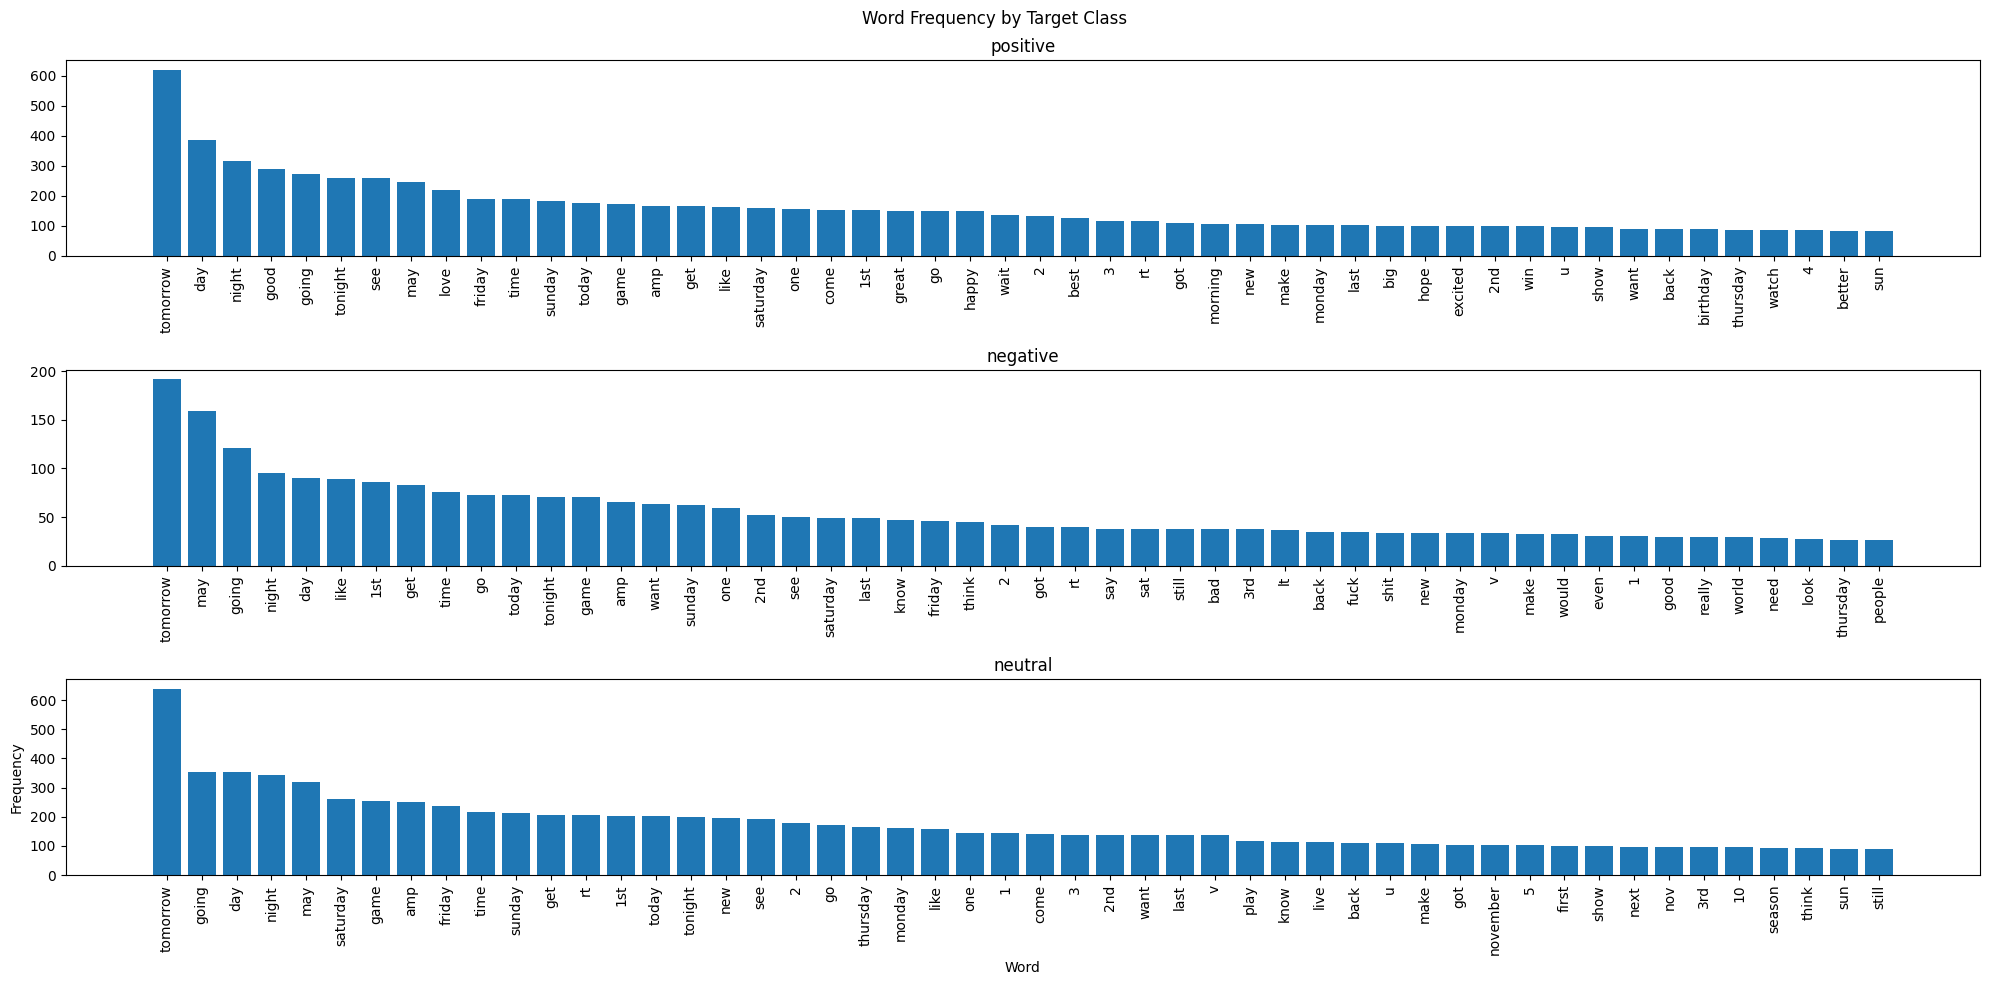

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Define a function to get the word frequency for a given class
def get_word_frequency(dataframe, target_class):
  tweets = dataframe[dataframe['y'] == target_class]['clean_x'].values.tolist()
  text = ' '.join(tweets)
  words = text.split()
  word_frequency = Counter(words)
  
  return word_frequency

# Define a function to plot a grouped bar chart of the most significant words for each class
def plot_word_frequency(dataframe, classes, top_n=50):

  fig, axs = plt.subplots(len(classes), 1, figsize=(20, 10))
  
  for i, target_class in enumerate(classes):
    word_frequency = get_word_frequency(dataframe, target_class)
    
    top_words = [word for word, count in word_frequency.most_common(top_n)]
    top_counts = [count for word, count in word_frequency.most_common(top_n)]
    
    axs[i].bar(top_words, top_counts)
    axs[i].set_title(target_class)
    axs[i].tick_params(axis='x', rotation=90)

  fig.suptitle('Word Frequency by Target Class')
  plt.xlabel('Word')
  plt.ylabel('Frequency')
  plt.tight_layout()
  plt.show()


classes = ['positive', 'negative', 'neutral']
plot_word_frequency(train_df, classes)


From the above plot, it is difficult to have comparative analysis between words and different target classes.  
Therefore, I am going to plot grouped bar chart of word frequenct by the target class.

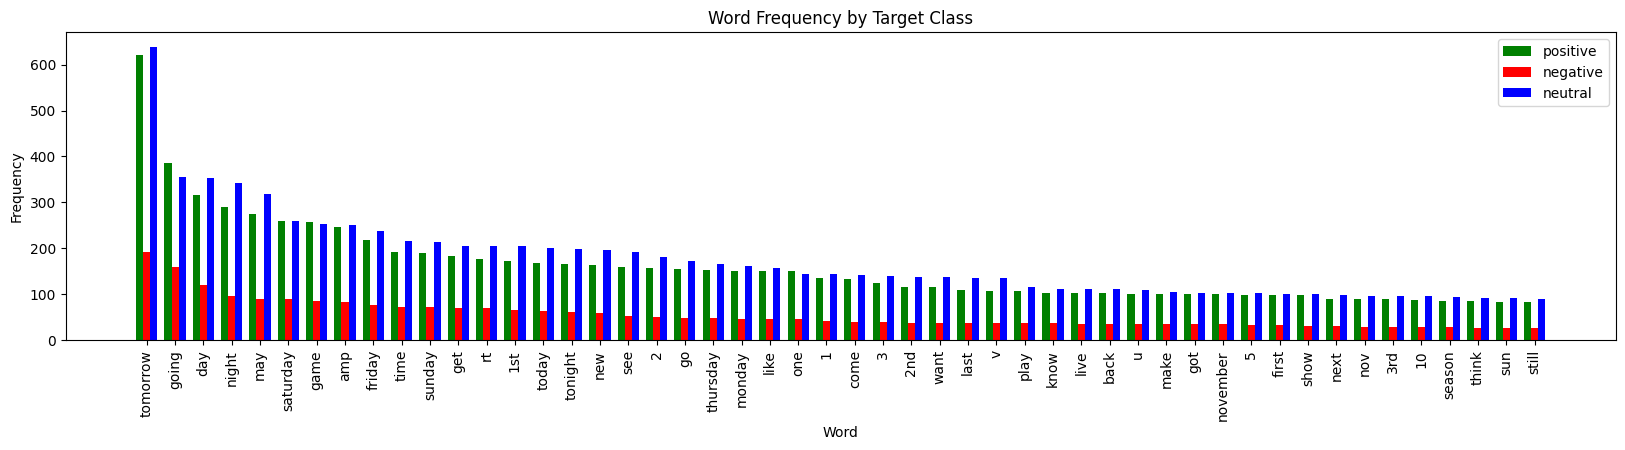

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Define a function to get the word frequency for a given class
def get_word_frequency(dataframe, target_class):
    tweets = dataframe[dataframe['y'] == target_class]['clean_x'].values.tolist()
    text = ' '.join(tweets)
    words = text.split()
    word_frequency = Counter(words)
  
    return word_frequency

# Define a function to plot a grouped bar chart of the most significant words for each class
def plot_word_frequency(dataframe, classes, top_n=50):
    fig, ax = plt.subplots(figsize=(20, 4))
  
    colors = ['g', 'r', 'b']
    for i, target_class in enumerate(classes):
        word_frequency = get_word_frequency(dataframe, target_class)
    
        top_words = [word for word, count in word_frequency.most_common(top_n)]
        top_counts = [count for word, count in word_frequency.most_common(top_n)]
    
        ax.bar([w + i*0.25 for w in range(top_n)], top_counts, width=0.25, label=target_class, color=colors[i])
        ax.set_xticks([w + 0.25 for w in range(top_n)])
        ax.set_xticklabels(top_words, rotation=90)
  
    ax.set_title('Word Frequency by Target Class')
    ax.set_xlabel('Word')
    ax.set_ylabel('Frequency')
    ax.legend()
    plt.show()

# Example usage:
classes = ['positive', 'negative', 'neutral']
plot_word_frequency(train_df, classes, top_n=50)


> **Finding 5**: Comparing the word frequency distribution of the words in the tweets for the three classes, I find that there are no words that could be used as a marker/sign of a particular class.

I would also like to have a table that consists the frequency of the word on each classes.

In [ ]:
word_frequency_by_class = {target_class: get_word_frequency(train_df, target_class) for target_class in classes}
word_frequency_df = pd.DataFrame(word_frequency_by_class)
word_frequency_df = word_frequency_df.fillna(0)
word_frequency_df = word_frequency_df.reset_index()
word_frequency_df = word_frequency_df.rename(columns={'index': 'word'})
word_frequency_df = word_frequency_df.set_index('word')
word_frequency_df = word_frequency_df.loc[(word_frequency_df > 1.0).any(axis=1)]

word_frequency_df

,positive,negative,neutral
word,,,
gas,1.0,1.0,4.0
house,39.0,6.0,48.0
hit,18.0,11.0,29.0
3,116.0,23.0,139.0
39,2.0,2.0,2.0
...,...,...,...
awareness,0.0,0.0,2.0
hou,0.0,0.0,2.0
boris,0.0,0.0,2.0


> **Finding 6:** There are 5,466 unique words in the entire dataset, which is only a small portion of the English language vocabulary. This suggests that the data can be prone to overfitting issues, and third-party word embeddings can be helpful. It also helps me decide the 'vocabulary size' parameter for the word embedding tasks.

**Plotting the unique words only**

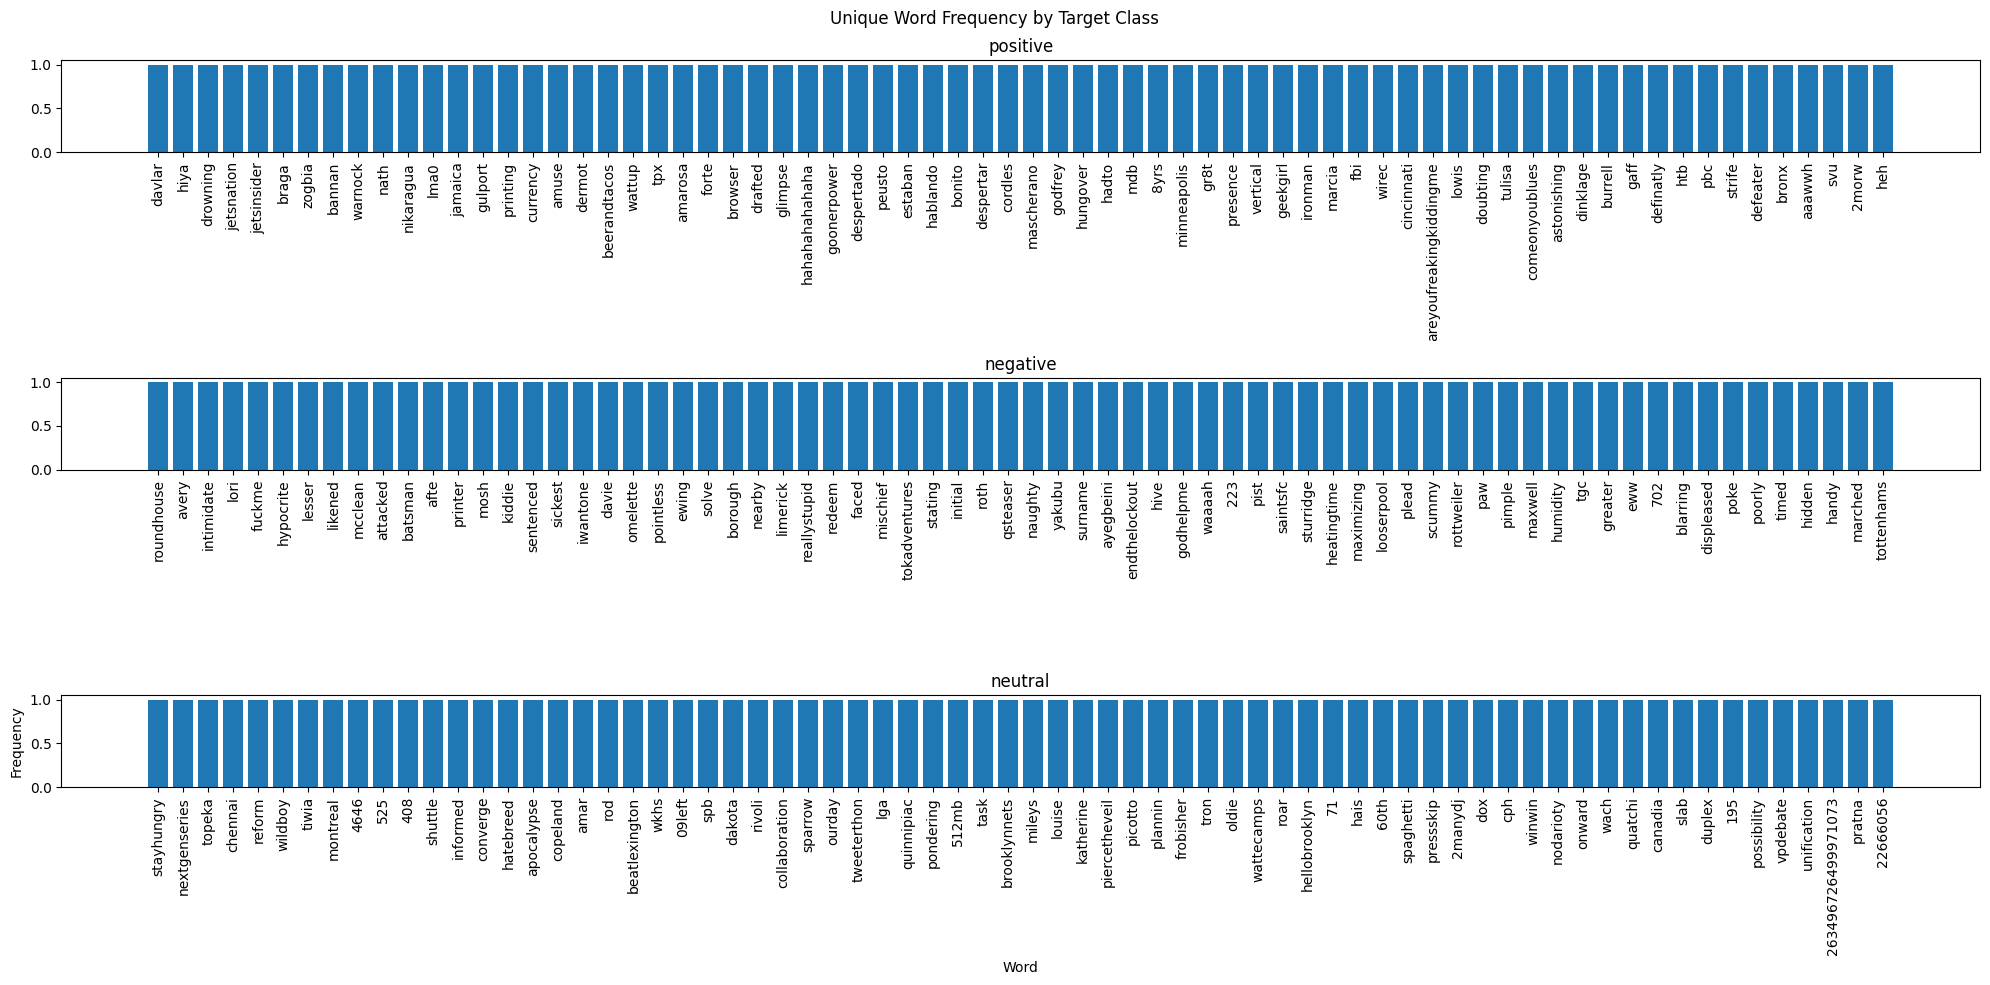

In [ ]:
# Define a function to get the unique words for each class
def get_unique_words(dataframe, classes):
  word_frequency_by_class = {target_class: get_word_frequency(dataframe, target_class) for target_class in classes}
  word_frequency_df = pd.DataFrame(word_frequency_by_class)
  word_frequency_df = word_frequency_df.fillna(0)
  word_frequency_df = word_frequency_df.reset_index()
  word_frequency_df = word_frequency_df.rename(columns={'index': 'word'})
  word_frequency_df = word_frequency_df.set_index('word')
  
  # Get words that occur only once in a given class and not at all in the other two classes
  unique_words = []
  for word in word_frequency_df.index:
    counts = word_frequency_df.loc[word].values
    if (counts == 1).sum() == 1 and (counts == 0).sum() == 2:
      unique_words.append(word)
  
  # Create a new dataframe with the unique words for each class
  unique_word_frequency_df = word_frequency_df.loc[unique_words]
  
  return unique_word_frequency_df

# Define a function to plot a grouped bar chart of the most significant unique words for each class
def plot_unique_word_frequency(dataframe, classes, top_n=70):

  fig, axs = plt.subplots(len(classes), 1, figsize=(20, 10))
  
  for i, target_class in enumerate(classes):
    unique_word_frequency = get_unique_words(dataframe, classes)
    unique_word_frequency = unique_word_frequency.fillna(0)
    top_words = unique_word_frequency[target_class].sort_values(ascending=False).head(top_n).index.tolist()
    top_counts = unique_word_frequency.loc[top_words][target_class].tolist()
    
    axs[i].bar(top_words, top_counts)
    axs[i].set_title(target_class)
    axs[i].tick_params(axis='x', rotation=90)

  fig.suptitle('Unique Word Frequency by Target Class')
  plt.xlabel('Word')
  plt.ylabel('Frequency')
  plt.subplots_adjust(top=0.95)
  plt.tight_layout()
  plt.show()


classes = ['positive', 'negative', 'neutral']
plot_unique_word_frequency(train_df, classes)


## After preprocessing the raw tweets, I am going to create models for the sentiment prediction of the tweets.

### Preparing integer sequence datasets - Text Vectorization
By default, the TextVectorization layer will use the setting “convert to lowercase and remove punctuation” for text standardization, and “split on whitespace” for tokenization.  

From the Exploratory Data Analysis, we know that anything above 150 character can be considered as an outlier. Therefore, I am setting `output_sequence_length` to 150.  

Reference: https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

In [ ]:
from tensorflow.keras import layers
import tensorflow as tf

batch_size = 32
max_length = 150
max_tokens = 20000 # Max size of the vocabulary

# Create TextVectorization layer
text_vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)

# Adapt the TextVectorization layer to the training data
train_text = train_df['clean_x'].values.tolist()
text_vectorizer.adapt(train_text)


# Apply the TextVectorization layer to the training data
int_train_ds = tf.data.Dataset.from_tensor_slices((train_df['clean_x'].values, y_train))
int_train_ds = int_train_ds.map(lambda x, y: (text_vectorizer(x), y)).batch(batch_size)

# Apply the TextVectorization layer to the test data
int_val_ds = tf.data.Dataset.from_tensor_slices((val_df['clean_x'].values, y_val))
int_val_ds = int_val_ds.map(lambda x, y: (text_vectorizer(x), y)).batch(batch_size)

# Apply the TextVectorization layer to the test data
int_test_ds = tf.data.Dataset.from_tensor_slices((test_df['clean_x'].values, y_test))
int_test_ds = int_test_ds.map(lambda x, y: (text_vectorizer(x), y)).batch(batch_size)

In [ ]:
for x, y in int_train_ds.take(1):
    print("Text:", x.shape)
    print("Target:", y.shape)

Text: (32, 150)
Target: (32, 3)


### Next, I would like to create modular functions that can be used on multiple model training.

**First, I will create a function to plot training and validation loss over time**

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(model_history):
  # Plot the training and validation accuracy over time
  plt.plot(model_history.history['accuracy'])
  plt.plot(model_history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  # Plot the training and validation loss over time
  plt.plot(model_history.history['loss'])
  plt.plot(model_history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()


**Then, a function to check model's accuracy and ground truth**

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
np.set_printoptions(threshold=np.inf)
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model_location):

  # Evaluate the model on the test set
  model = keras.models.load_model(model_location)
  test_loss, test_acc = model.evaluate(int_test_ds)
  print(f"Test accuracy: {test_acc:.3f}")
  print(f"Test loss: {test_loss:.3f}")

  # Make predictions on the test set
  test_pred = model.predict(int_test_ds)

  # Extract the predicted labels for each class
  y_pred = np.argmax(test_pred, axis=1)

  # Extract the ground truth labels for each class
  y_true = np.concatenate([y for x, y in int_test_ds], axis=0)
  y_true = np.argmax(y_true, axis=1)

  positive_true = (y_true == 2).sum()
  negative_true = (y_true == 0).sum()
  neutral_true = (y_true == 1).sum()

  # Calculate the evaluation metrics
  accuracy = accuracy_score(y_true, y_pred)
  precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=1.0)
  conf_matrix = confusion_matrix(y_true, y_pred)

  print("\nShape of y: ", y_true.shape)

  # Print the evaluation metrics
  print('\nAccuracy:', accuracy)
  print('Precision:', precision)
  print('Recall:', recall)
  print('F1-score:', f1)
  print('\nClassification Report:')
  print(classification_report(y_true, y_pred))
  # print('Confusion Matrix:')
  # print(conf_matrix)

  print("Ground Truth: ", y_true[:10])
  print("Prediction: ", y_pred[:10])
  # print("Prediction Probabilities: ", test_pred[:10])

  print(f"Positive Ground Truth: {positive_true}")
  print(f"Negative Ground Truth: {negative_true}")
  print(f"Neutral Ground Truth: {neutral_true}")

  # Plot the confusion matrix
  plt.figure(figsize=(6, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
              xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.show()




---



### Building Bi-directional LSTM model  
**Motivation to use Bi-directional LSTM:** Since tweets are often short and lack context, it can be difficult to accurately classify the sentiment of a tweet using only the immediate context. However, by using a BiLSTM model that can take into account both past and future context information, we can improve the accuracy of sentiment analysis on Twitter data.

In addition, BiLSTM models are also useful for handling cases where the sentiment of a sentence may depend on the entire sentence rather than just individual words. This is because BiLSTM models are capable of capturing long-term dependencies and correlations between different parts of the input sequence, allowing them to better capture the overall sentiment of a sentence.

Overall, BiLSTM models are a powerful tool for sentiment analysis on sequential data such as text, and can be particularly useful for analyzing short, context-poor data like tweets.

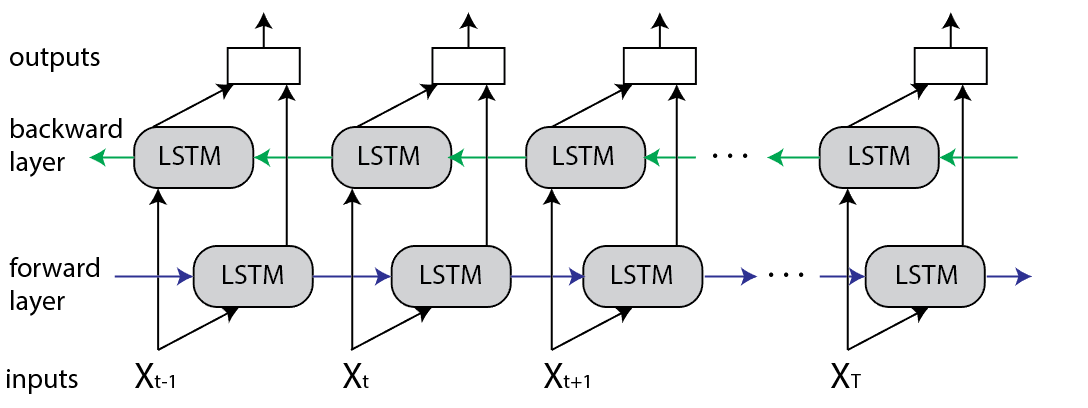

Reference: https://towardsdatascience.com/from-a-lstm-cell-to-a-multilayer-lstm-network-with-pytorch-2899eb5696f3 , https://www.baeldung.com/cs/bidirectional-vs-unidirectional-lstm


#### There are different approaches to represent text data in a numerical format. First, I will start **with One-hot encoded vector sequence**.
One-hot encoded vector sequences represent each word in a text as a binary vector where only one element is set to 1 and all other elements are set to 0. The position of the 1 corresponds to the index of the word in a pre-defined vocabulary. For example, if our vocabulary contains the words ["cat", "dog", "bird"], the word "dog" would be represented as the vector [0, 1, 0]. 

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot_2 (TFOpLambda)   (None, None, 20000)       0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 32)               2562176   
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 2,562,275
Trainable params: 2,562,275
Non-trainable params: 0
_________________________________________________

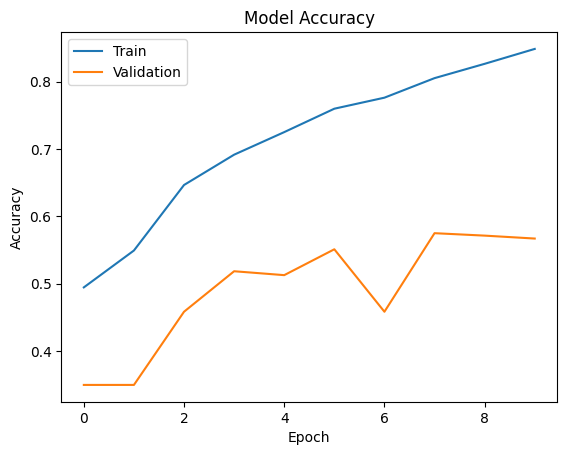

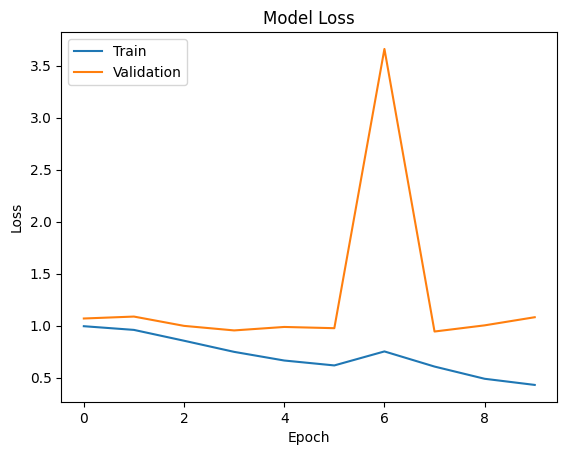

99/99 [==============================] - 5s 33ms/step - loss: 0.9019 - accuracy: 0.6012
Test accuracy: 0.601
Test loss: 0.902
99/99 [==============================] - 4s 29ms/step

Shape of y:  (3137,)

Accuracy: 0.6012113484220593
Precision: 0.5943931136488819
Recall: 0.6012113484220593
F1-score: 0.5944551765191209

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.32      0.37       472
           1       0.63      0.60      0.62      1384
           2       0.61      0.70      0.65      1281

    accuracy                           0.60      3137
   macro avg       0.56      0.54      0.55      3137
weighted avg       0.59      0.60      0.59      3137

Ground Truth:  [2 1 0 1 1 2 2 2 1 2]
Prediction:  [2 1 0 2 1 2 1 2 1 2]
Positive Ground Truth: 1281
Negative Ground Truth: 472
Neutral Ground Truth: 1384


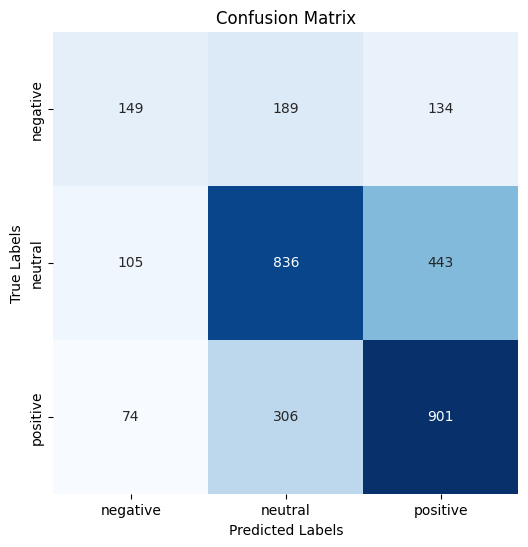

In [ ]:
from tensorflow import keras

num_classes = 3

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.LSTM(16))(embedded)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

# Train the model for a fixed number of epochs
callbacks = [
    keras.callbacks.ModelCheckpoint("checkpoints/one_hot_bidir_lstm_val.keras",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
plot_training_history(history)
evaluate_model("checkpoints/one_hot_bidir_lstm_val.keras")

> **Finding 7:** The first model trained, a Bi-LSTM with one-hot encoded vector sequence, achieves an accuracy of 60.1% on the test dataset in 5 epochs. After five epochs, the model starts to overfit.  
Possible reason for this overfitting might be *Complex model, insufficient amount of data.* <br>
Possible address to overfitting problem:
1. Reduce model complexity
2. Add regularization
3. Use data augmentation
4. Use early stopping
5. Increase the amount of training data.



One-hot encoding is simple and straightforward to implement, but it suffers from a high-dimensional and sparse representation, which can make it difficult to handle in deep learning models.

**I would like to implement Weighted training to check if the imbalanced training data might have impacted on the performance of above model.**

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights based on the training data
class_labels = np.unique(train_df['y'])
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_df['y']),
                                        y = train_df['y']                                                    
                                    )

# Convert class weights to a dictionary
class_weights_dict_label = dict(zip(class_labels, class_weights))
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict_label)
print(class_weights_dict)

{'negative': 2.301409260857061, 'neutral': 0.6894115619884552, 'positive': 0.896884106702533}
{0: 2.301409260857061, 1: 0.6894115619884552, 2: 0.896884106702533}


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot_1 (TFOpLambda)   (None, None, 20000)       0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               2562176   
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 2,562,275
Trainable params: 2,562,275
Non-trainable params: 0
_________________________________________________

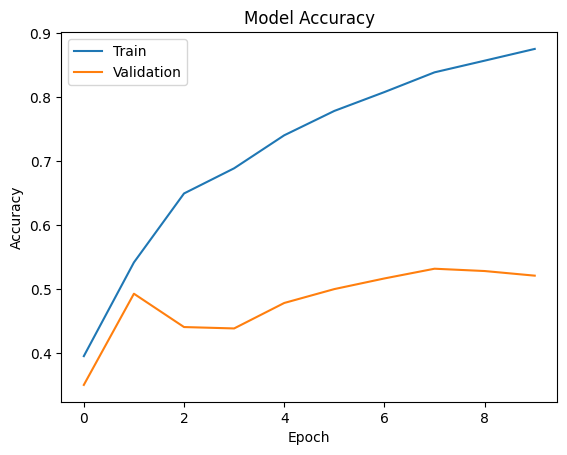

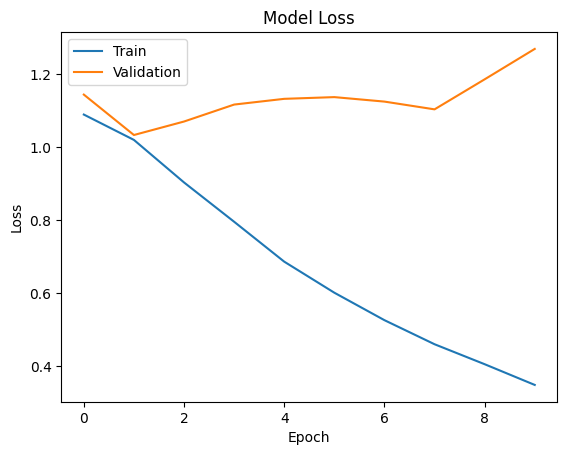

99/99 [==============================] - 4s 32ms/step - loss: 1.0079 - accuracy: 0.5237
Test accuracy: 0.524
Test loss: 1.008
99/99 [==============================] - 4s 29ms/step

Shape of y:  (3137,)

Accuracy: 0.523748804590373
Precision: 0.5854493051291805
Recall: 0.523748804590373
F1-score: 0.5282682723300611

Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.44      0.31       472
           1       0.69      0.38      0.49      1384
           2       0.59      0.71      0.65      1281

    accuracy                           0.52      3137
   macro avg       0.51      0.51      0.48      3137
weighted avg       0.59      0.52      0.53      3137

Ground Truth:  [2 1 0 1 1 2 2 2 1 2]
Prediction:  [2 1 0 1 0 2 1 2 0 2]
Positive Ground Truth: 1281
Negative Ground Truth: 472
Neutral Ground Truth: 1384


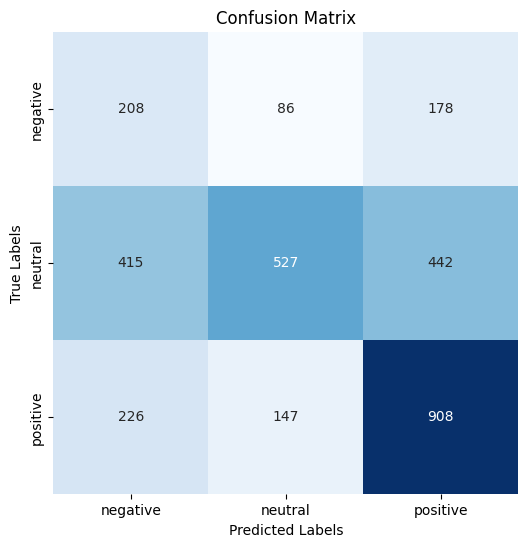

In [ ]:
from tensorflow import keras

num_classes = 3

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.LSTM(16))(embedded)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

# Train the model for a fixed number of epochs
callbacks = [
    keras.callbacks.ModelCheckpoint("checkpoints/one_hot_bidir_lstm_weighted.keras",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10,  class_weight=class_weights_dict, callbacks=callbacks)
plot_training_history(history)
evaluate_model("checkpoints/one_hot_bidir_lstm_weighted.keras")

> **Finding 8:** 'Class weighting', to account for the imbalanced dataset, did not improve the accuracy of the Bi-LSTM model.

#### Second, Implementing **Word Embedding**. 
Word embeddings capture semantic relationships between words, such as synonyms or related concepts, and can be used to represent the meaning of words in a more compact and meaningful way. Word embeddings can be fed directly into deep learning models, and their dense representation makes them easier to handle and more computationally efficient than one-hot encoded vectors.

#####Training Word Embedding from scratch

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 8)           160000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               3200      
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 163,299
Trainable params: 163,299
Non-trainable params: 0
_____________________________________________________

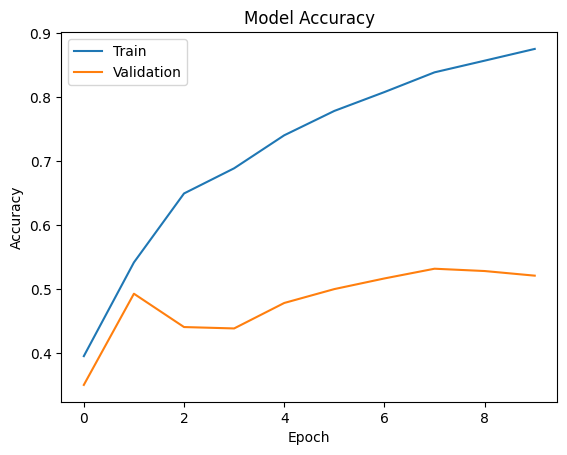

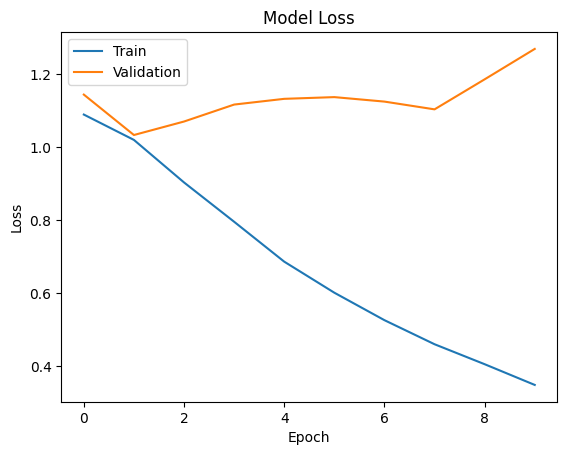

99/99 [==============================] - 3s 17ms/step - loss: 0.8862 - accuracy: 0.5891
Test accuracy: 0.589
Test loss: 0.886
99/99 [==============================] - 3s 19ms/step

Shape of y:  (3137,)

Accuracy: 0.5890978642014664
Precision: 0.5787301853332525
Recall: 0.5890978642014664
F1-score: 0.5721467096526982

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.19      0.27       472
           1       0.63      0.58      0.60      1384
           2       0.58      0.75      0.65      1281

    accuracy                           0.59      3137
   macro avg       0.55      0.51      0.51      3137
weighted avg       0.58      0.59      0.57      3137

Ground Truth:  [2 1 0 1 1 2 2 2 1 2]
Prediction:  [2 1 2 1 1 2 1 2 1 1]
Positive Ground Truth: 1281
Negative Ground Truth: 472
Neutral Ground Truth: 1384


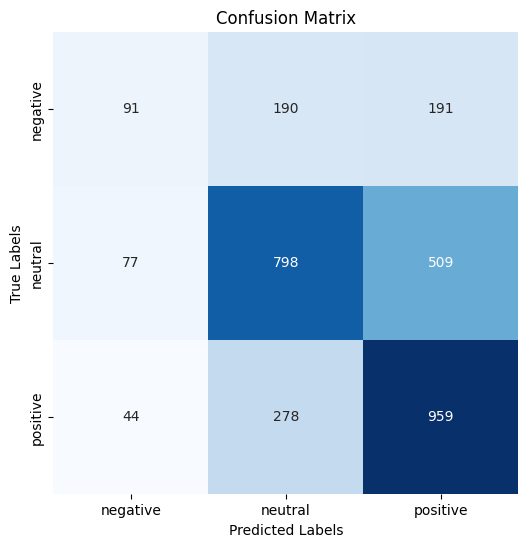

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=8)(inputs)
x = layers.Bidirectional(layers.LSTM(16))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("checkpoints/embeddings_bidir_gru.keras",
                                    save_best_only=True)
]
hostory = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
plot_training_history(history)
evaluate_model("checkpoints/embeddings_bidir_gru.keras")

> **Finding 9:** Using the 'self-trained word embedding' also did not improve the accuracy of the Bi-LSTM model.

**Let's use "embedded" layer with masking enabled** -  This ignores the padding tokens when the sequence of the tweet is less than 'max_length' (i.e, 150) since it does not contain any meaningful information.

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 8)           160000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 32)               3200      
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 3)                 99        
                                                                 
Total params: 163,299
Trainable params: 163,299
Non-trainable params: 0
_____________________________________________________

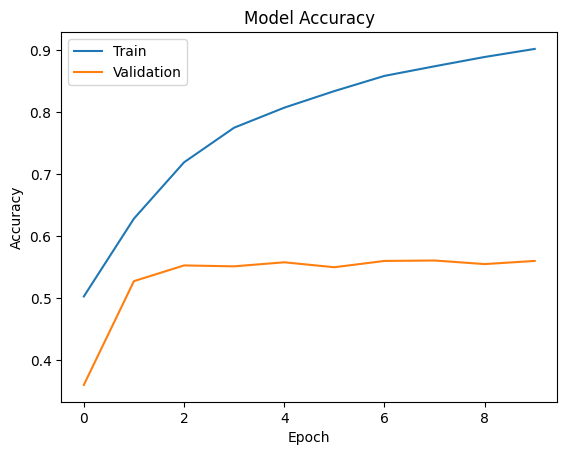

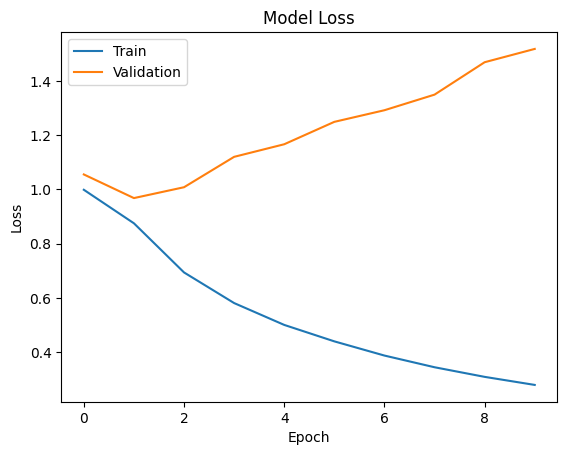

99/99 [==============================] - 4s 14ms/step - loss: 0.8946 - accuracy: 0.5840
Test accuracy: 0.584
Test loss: 0.895
99/99 [==============================] - 4s 8ms/step

Shape of y:  (3137,)

Accuracy: 0.5839974497927957
Precision: 0.5753943116946603
Recall: 0.5839974497927957
F1-score: 0.5372016592653598

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.00      0.00       472
           1       0.62      0.65      0.63      1384
           2       0.55      0.73      0.63      1281

    accuracy                           0.58      3137
   macro avg       0.56      0.46      0.42      3137
weighted avg       0.58      0.58      0.54      3137

Ground Truth:  [2 1 0 1 1 2 2 2 1 2]
Prediction:  [2 1 2 1 1 2 1 2 1 2]
Positive Ground Truth: 1281
Negative Ground Truth: 472
Neutral Ground Truth: 1384


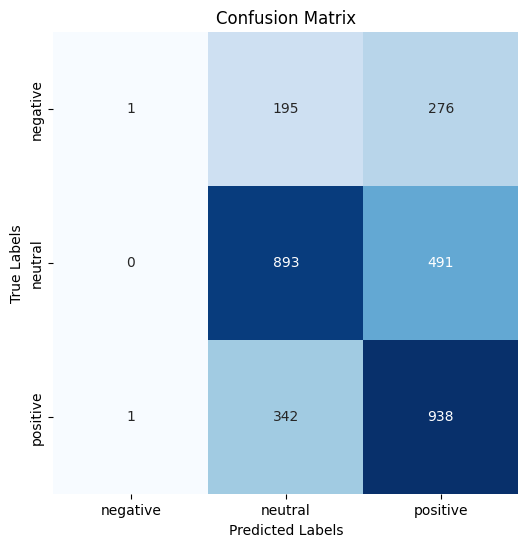

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=8, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(16))(embedded)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("checkpoints/embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
plot_training_history(history)
evaluate_model("checkpoints/embeddings_bidir_gru_with_masking.keras")

> **Finding 10:** The use of padding in the embedding also did not improve the model's accuracy.

Analysis: The test accuracy has slightly increased because of masking.

#####Using pretrained word embeddings

Many pretrained word embedding such as Word2Vec, GloVe, or FastText exists.These algorithms generate word embeddings that capture semantic relationships between words, such as synonyms or related concepts, and can be used to represent the meaning of words in a more compact and meaningful way. Word embeddings can be fed directly into deep learning models, and their dense representation makes them easier to handle and more computationally efficient than one-hot encoded vectors.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-04-08 13:52:52--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-08 13:52:53--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-08 13:52:53--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [ ]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [ ]:
embedding_dim = 100

vocabulary = text_vectorizer.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 100)         2000000   
                                                                 
 bidirectional_6 (Bidirectio  (None, 16)               6976      
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 3)                 51        
                                                                 
Total params: 2,007,027
Trainable params: 7,027
Non-trainable params: 2,000,000
_____________________________________________

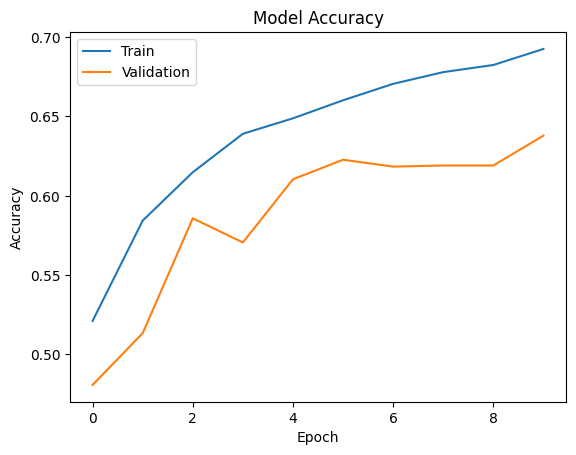

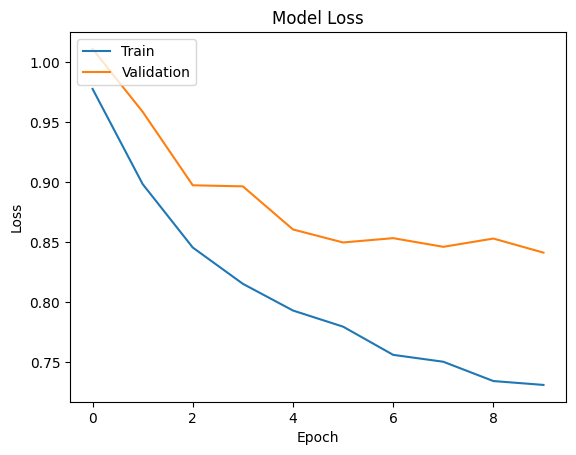

99/99 [==============================] - 4s 8ms/step - loss: 0.7828 - accuracy: 0.6544
Test accuracy: 0.654
Test loss: 0.783
99/99 [==============================] - 3s 8ms/step

Shape of y:  (3137,)

Accuracy: 0.6544469238125598
Precision: 0.6506729138291312
Recall: 0.6544469238125598
F1-score: 0.6502030160000711

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.40      0.46       472
           1       0.65      0.73      0.69      1384
           2       0.69      0.66      0.68      1281

    accuracy                           0.65      3137
   macro avg       0.63      0.60      0.61      3137
weighted avg       0.65      0.65      0.65      3137

Ground Truth:  [2 1 0 1 1 2 2 2 1 2]
Prediction:  [2 1 2 1 0 2 1 2 1 1]
Positive Ground Truth: 1281
Negative Ground Truth: 472
Neutral Ground Truth: 1384


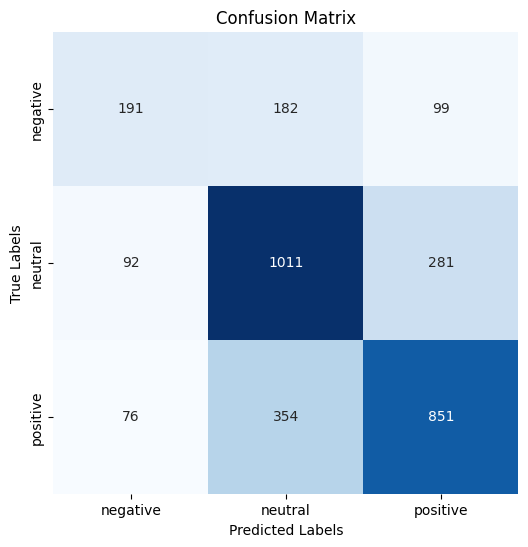

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(8))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("checkpoints/glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
plot_training_history(history)
evaluate_model("checkpoints/glove_embeddings_sequence_model.keras")

> **Finding 11:** Replacing word embeddings trained locally with `GloVe` embedding increased the accuracy to 65%, **around a 5% increase**. Similar improvement is observed across other metrics (precision, recall, and F1-score).

### Building Transformer model since they are highly preffered on the Natural Language Processing task.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [ ]:
vocab_size = 20000
embed_dim = 150
num_heads = 2
dense_dim = 32
output_dim = 3

inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(output_dim, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 150)         3000000   
                                                                 
 transformer_encoder (Transf  (None, None, 150)        191432    
 ormerEncoder)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 150)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_7 (Dropout)         (None, 150)               0         
                                                                 
 dense_9 (Dense)             (None, 3)                 453 

Epoch 1/10
251/251 [==============================] - 26s 81ms/step - loss: 1.0717 - accuracy: 0.5230 - val_loss: 1.0333 - val_accuracy: 0.4439
Epoch 2/10
251/251 [==============================] - 4s 14ms/step - loss: 0.7691 - accuracy: 0.6747 - val_loss: 0.9391 - val_accuracy: 0.5438
Epoch 3/10
251/251 [==============================] - 4s 14ms/step - loss: 0.6298 - accuracy: 0.7472 - val_loss: 0.9755 - val_accuracy: 0.5503
Epoch 4/10
251/251 [==============================] - 4s 15ms/step - loss: 0.5245 - accuracy: 0.7966 - val_loss: 1.0046 - val_accuracy: 0.5684
Epoch 5/10
251/251 [==============================] - 3s 14ms/step - loss: 0.4371 - accuracy: 0.8349 - val_loss: 0.9821 - val_accuracy: 0.5909
Epoch 6/10
251/251 [==============================] - 4s 17ms/step - loss: 0.3562 - accuracy: 0.8638 - val_loss: 1.0962 - val_accuracy: 0.5706
Epoch 7/10
251/251 [==============================] - 3s 13ms/step - loss: 0.2922 - accuracy: 0.8923 - val_loss: 1.1333 - val_accuracy: 0.578

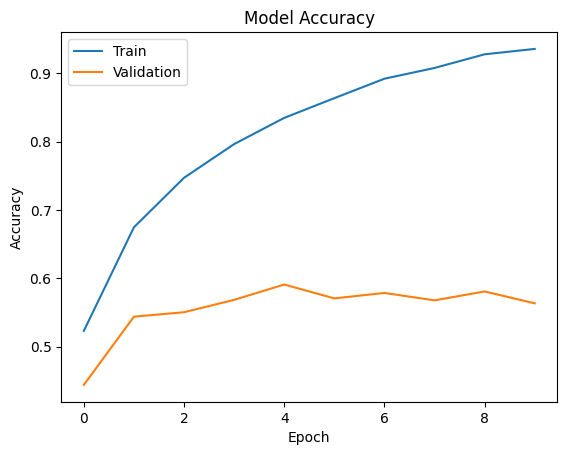

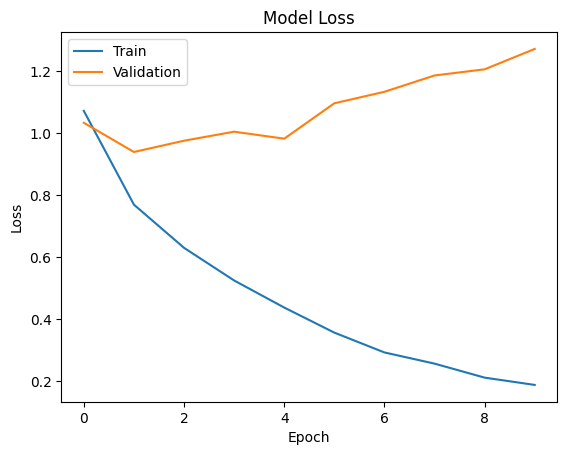

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("checkpoints/transformer_encoder.keras",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
plot_training_history(history)

In [ ]:

model = keras.models.load_model(
    "checkpoints/transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

99/99 [==============================] - 1s 8ms/step - loss: 0.8878 - accuracy: 0.5834
Test acc: 0.583


> **Finding 12:** The second model trained, a transformer network, only achieved an accuracy of 58.3% accuracy. Since transformer networks work well when the dataset is large, I assume that this is 'expected' for our dataset. 

##**Note**
- The links at this [url](https://alt.qcri.org/semeval2014/task9/index.php?id=data-and-tools) do not work.
- The helpful [link](https://pythonfordatascience.org/inferential-statistics/) for Inferential Statistics does not work as well. 